In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [82]:
df = pd.DataFrame(columns=["i", 'j', "reg", "X", "Y"])
df.head()
lastKDays = 10

In [84]:
for i in range(6):
    for j in range(5):
        try:
            gp = np.load(f"../exp2/src/results/{lastKDays}/final_gp/{i}_{j}/final_rmse.npy")
            qbc = np.load(f"../exp2/src/results/{lastKDays}/final_qbc/{i}_{j}/final_rmse.npy")
            qbc_rd = np.load(f"../exp2/src/results/{lastKDays}/final_random_qbc/{i}_{j}/final_rmse.npy")
            for reg, temp in zip(["gp", "qbc", "qbc_rd"], [gp, qbc, qbc_rd.mean(axis=0)]):
                store = {
                    'i': [i]*len(list(temp)),
                    'j': [j]*len(list(temp)),
                    'reg': [reg] * len(list(temp)),
                    "X": [i for i in range(len(temp))],
                    "Y": temp,
                }
                tempdf = pd.DataFrame(store)
                df = df.append(tempdf, ignore_index=True)
            
        except Exception as e:
            print (len(gp))
            print (e)
#             raise ValueError

356
[Errno 2] No such file or directory: '../exp2/src/results/10/final_gp/5_0/final_rmse.npy'
356
[Errno 2] No such file or directory: '../exp2/src/results/10/final_gp/5_1/final_rmse.npy'
356
[Errno 2] No such file or directory: '../exp2/src/results/10/final_gp/5_2/final_rmse.npy'
356
[Errno 2] No such file or directory: '../exp2/src/results/10/final_gp/5_3/final_rmse.npy'
356
[Errno 2] No such file or directory: '../exp2/src/results/10/final_gp/5_4/final_rmse.npy'


In [85]:
import seaborn as sns

In [86]:
df.head()

,i,j,reg,X,Y
0,0,0,gp,0,4.098668
1,0,0,gp,1,6.443400
2,0,0,gp,2,5.249915
3,0,0,gp,3,4.046290
4,0,0,gp,4,6.314935


                Y
reg              
gp      17.103356
qbc     20.392418
qbc_rd  21.785237


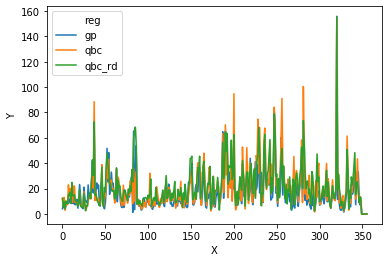

                Y
reg              
gp      18.390341
qbc     20.506336
qbc_rd  25.723702


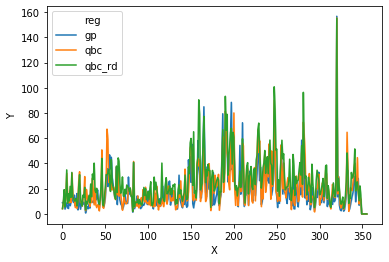

                Y
reg              
gp      17.985457
qbc     19.812565
qbc_rd  24.578681


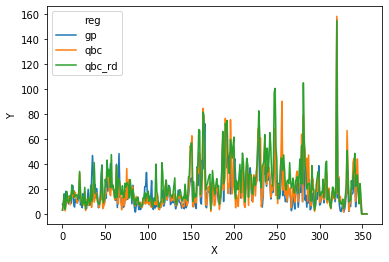

                Y
reg              
gp      16.982604
qbc     20.913641
qbc_rd  24.287898


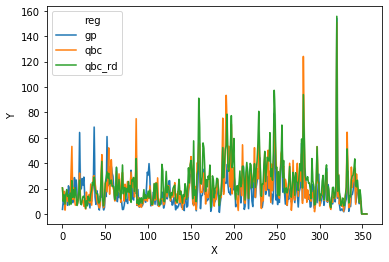

                Y
reg              
gp      15.973322
qbc     20.627610
qbc_rd  24.481995


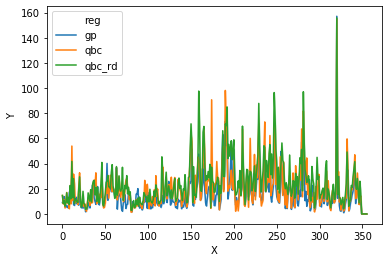

                Y
reg              
gp      19.214720
qbc     23.484347
qbc_rd  23.788818


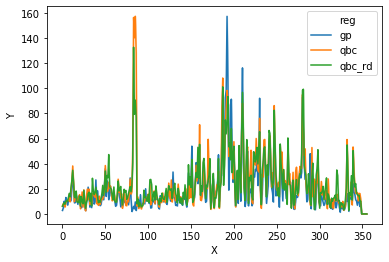

                Y
reg              
gp      33.664551
qbc     23.738331
qbc_rd  23.987747


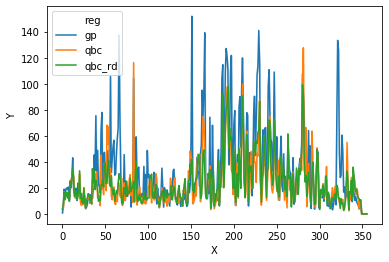

                Y
reg              
gp      21.466966
qbc     22.370836
qbc_rd  22.513015


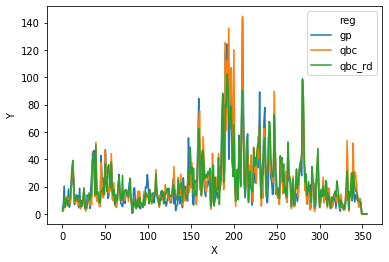

                Y
reg              
gp      22.175126
qbc     23.623725
qbc_rd  24.971901


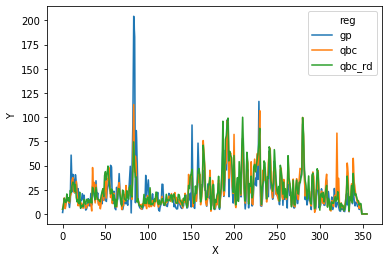

                Y
reg              
gp      22.351916
qbc     21.909515
qbc_rd  25.533935


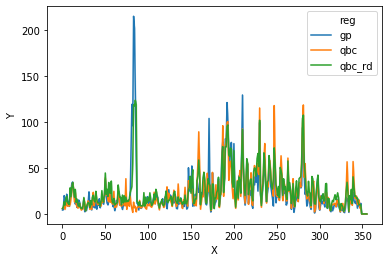

                Y
reg              
gp      21.824614
qbc     22.594496
qbc_rd  22.716117


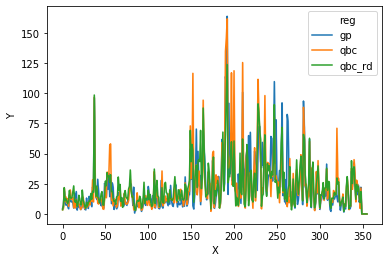

                Y
reg              
gp      22.215777
qbc     19.435360
qbc_rd  22.456374


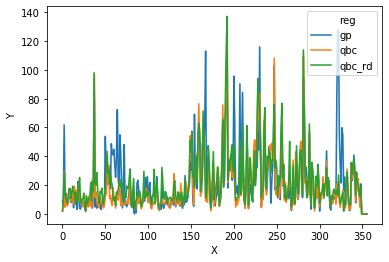

                Y
reg              
gp      23.172620
qbc     28.584910
qbc_rd  24.337487


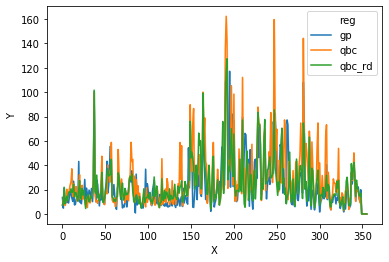

                Y
reg              
gp      19.559078
qbc     22.062197
qbc_rd  25.245278


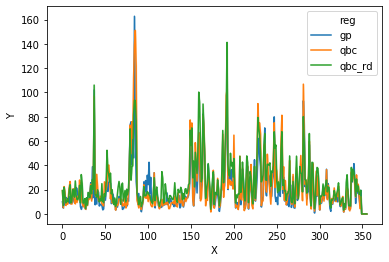

                Y
reg              
gp      21.855967
qbc     27.675250
qbc_rd  26.059181


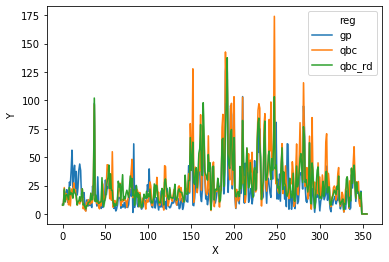

                Y
reg              
gp      18.471878
qbc     21.366500
qbc_rd  20.140753


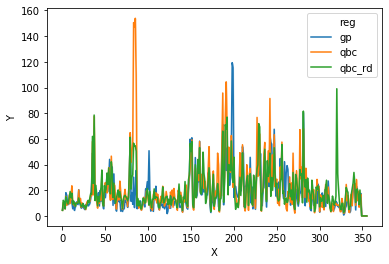

                Y
reg              
gp      17.589769
qbc     21.242125
qbc_rd  19.472479


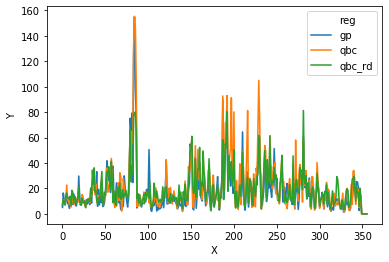

                Y
reg              
gp      17.028121
qbc     17.746907
qbc_rd  17.894682


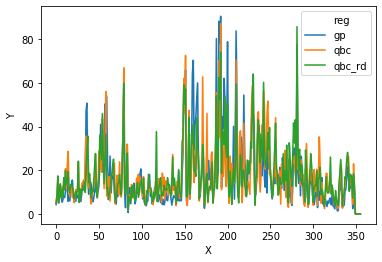

                Y
reg              
gp      16.969307
qbc     20.073875
qbc_rd  17.993089


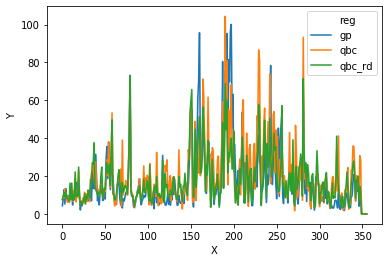

                Y
reg              
gp      17.567111
qbc     18.830459
qbc_rd  17.484924


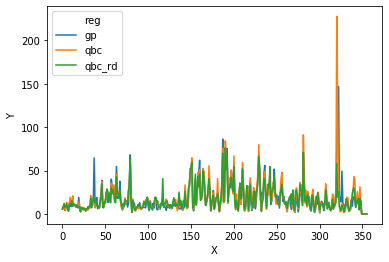

                Y
reg              
gp      23.615212
qbc     24.699683
qbc_rd  23.774833


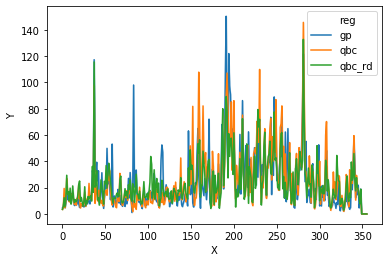

                Y
reg              
gp      25.223941
qbc     23.974693
qbc_rd  25.249313


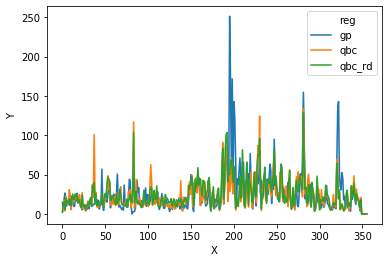

                Y
reg              
gp      19.445798
qbc     21.939027
qbc_rd  23.657017


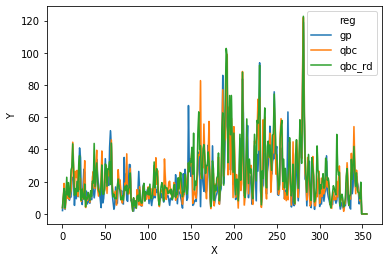

                Y
reg              
gp      23.478975
qbc     23.112742
qbc_rd  24.022059


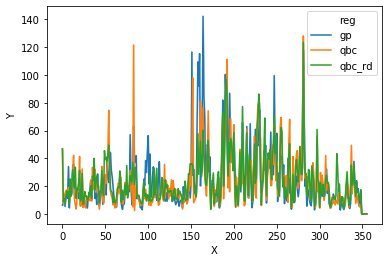

                Y
reg              
gp      18.470420
qbc     23.654268
qbc_rd  24.873747


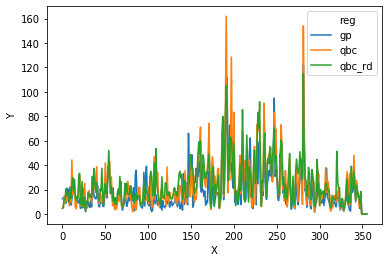

Empty DataFrame
Columns: [Y]
Index: []


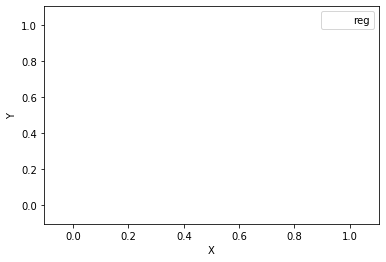

Empty DataFrame
Columns: [Y]
Index: []


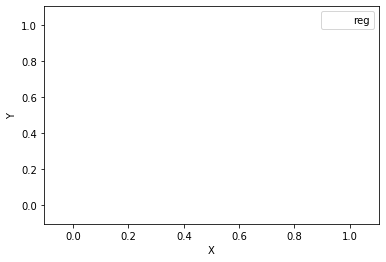

Empty DataFrame
Columns: [Y]
Index: []


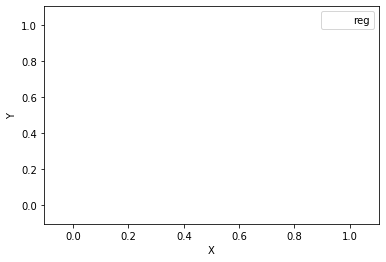

Empty DataFrame
Columns: [Y]
Index: []


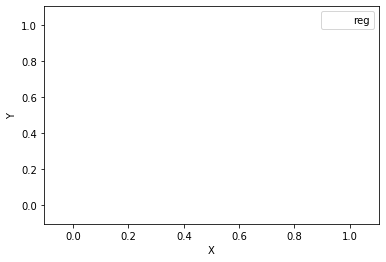

Empty DataFrame
Columns: [Y]
Index: []


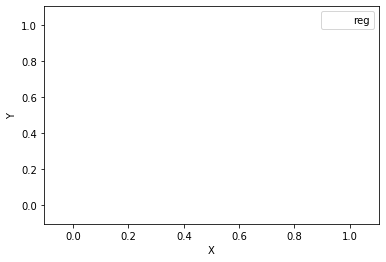

In [87]:
for i in range(6):
    for j in range(5):
        tmp = df[df['i']==i]
        tmp = tmp[tmp['j']==j]
        sns.lineplot(data=tmp, x="X", y="Y", hue="reg")
        print (tmp.groupby("reg").mean())
        plt.show()
#         break
#     break

In [88]:
df.groupby("reg").mean()

,Y
reg,
gp,20.471579
qbc,22.174873
qbc_rd,23.081210


In [37]:
len(gp), len(qbc), len(qbc_rd.mean(axis=0))

(346, 346, 346)

In [3]:
gp = np.load("../exp2/src/results/20/final_gp/0_0/final_rmse.npy")
qbc = np.load("../exp2/src/results/20/final_qbc/0_0/final_rmse.npy")
qbc_rd = np.load("../exp2/src/results/20/final_random_qbc/0_0/final_rmse.npy")


In [13]:
gp = gp[gp!=0]
qbc = qbc[qbc!=0]

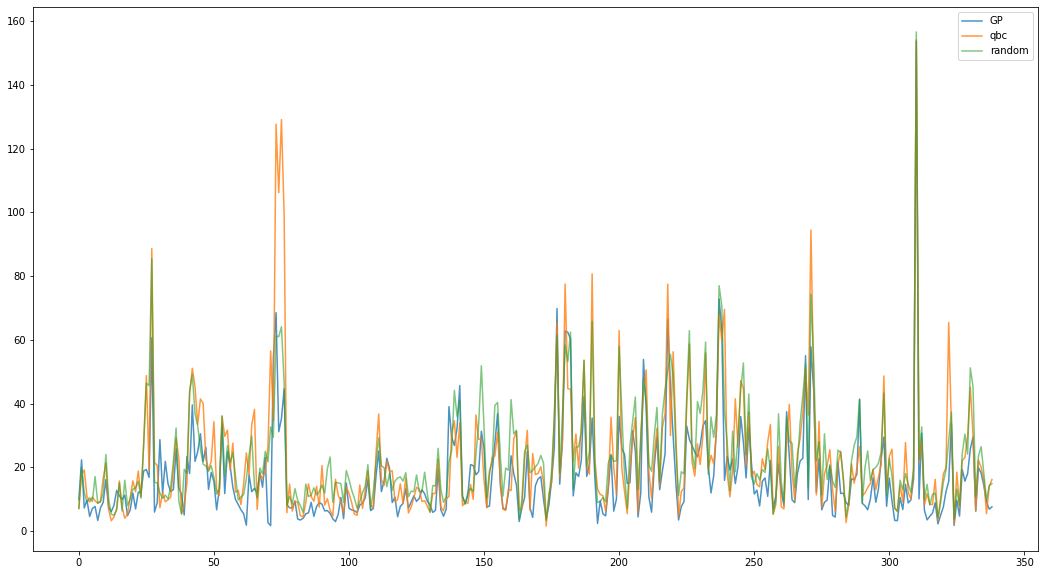

In [25]:
plt.figure(figsize=(18, 10))
plt.plot(gp, alpha= 0.8, label="GP")
plt.plot(qbc, alpha = 0.8, label="qbc")
plt.plot(mean, alpha = 0.6, label='random')
plt.legend()
# plt.plot(qbc_rd)

In [6]:
np.load("../exp2/src/results/20/final_gp/0_0/final_rmse.npy")
gp.mean(), qbc.mean()

(16.87702705582097, 21.959137708694254)

In [16]:
mean = qbc_rd.mean(axis = 0)
mean = mean[mean!=0]

In [ ]:
    for j in range(1,31,5):
        plt.axvline(j,ls='--',color='k',lw=0.5)
#     format_axes(plt.gca())
#     plt.errorbar([i for i in range(32)],random_final,yerr=stddev,marker='.',label='Random Sampling')


In [29]:
gp.shape

(346,)